In [1]:
from matplotlib import pyplot as plt

import numpy as np
import cv2 as cv


In [2]:
img = cv.imread('./images/baboon.png', cv.IMREAD_GRAYSCALE)

In [3]:
def warp_perspective(img, M, dsize):
    iY, iX = np.indices(dimensions=dsize)
    indexOutput = np.stack(
        (iX.ravel(), iY.ravel(), np.ones(iY.size))).astype(int)

    # inverse matrix
    IM = np.linalg.inv(M)
    indexInput = IM.dot(indexOutput)

    # :todo interpolation
    indexInput = np.round(indexInput / indexInput[2, :]).astype(int)

    # set zero value
    indexInput = indexInput.transpose()
    index = np.where((indexInput[:, 0] < 0) | (indexInput[:, 0] >= img.shape[0]) | (
        indexInput[:, 1] < 0) | (indexInput[:, 1] >= img.shape[1]))
    indexInput[index] = 0

    res = img[indexInput[:, 1], indexInput[:, 0]]
    return res.reshape(dsize)


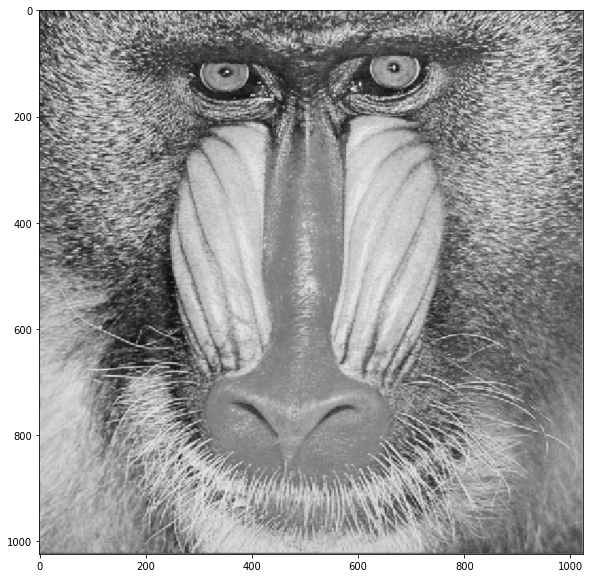

In [4]:
plt.figure(figsize=(10, 10))

""" tetha = -np.pi / 12
M = np.array([
    [np.cos(tetha), -np.sin(tetha), 0],
    [np.sin(tetha), np.cos(tetha), 0],
    [0, 0, 1]
], dtype='float32') """

M = np.array([
    [2, 0, 0],
    [0, 2, 0],
    [0, 0, 1]
], dtype='float32')
out = warp_perspective(img, M, (1024, 1024))
plt.imshow(out, cmap='gray')
